# Build a custom RAG agent with LangGraph

## Overview

In this tutorial we will build a [retrieval](/oss/python/langchain/retrieval) agent using LangGraph.

LangChain offers built-in [agent](/oss/python/langchain/agents) implementations, implemented using [LangGraph](/oss/python/langgraph/overview) primitives. If deeper customization is required, agents can be implemented directly in LangGraph. This guide demonstrates an example implementation of a retrieval agent. [Retrieval](/oss/python/langchain/retrieval) agents are useful when you want an LLM to make a decision about whether to retrieve context from a vectorstore or respond to the user directly.

By the end of the tutorial we will have done the following:

1. Fetch and preprocess documents that will be used for retrieval.
2. Index those documents for semantic search and create a retriever tool for the agent.
3. Build an agentic RAG system that can decide when to use the retriever tool.

<img src="https://mintcdn.com/langchain-5e9cc07a/I6RpA28iE233vhYX/images/langgraph-hybrid-rag-tutorial.png?fit=max&auto=format&n=I6RpA28iE233vhYX&q=85&s=855348219691485642b22a1419939ea7" alt="Hybrid RAG" data-og-width="1615" width="1615" data-og-height="589" height="589" data-path="images/langgraph-hybrid-rag-tutorial.png" data-optimize="true" data-opv="3" srcset="https://mintcdn.com/langchain-5e9cc07a/I6RpA28iE233vhYX/images/langgraph-hybrid-rag-tutorial.png?w=280&fit=max&auto=format&n=I6RpA28iE233vhYX&q=85&s=09097cb9a1dc57b16d33f084641ea93f 280w, https://mintcdn.com/langchain-5e9cc07a/I6RpA28iE233vhYX/images/langgraph-hybrid-rag-tutorial.png?w=560&fit=max&auto=format&n=I6RpA28iE233vhYX&q=85&s=d0bf85cfa36ac7e1a905593a4688f2d2 560w, https://mintcdn.com/langchain-5e9cc07a/I6RpA28iE233vhYX/images/langgraph-hybrid-rag-tutorial.png?w=840&fit=max&auto=format&n=I6RpA28iE233vhYX&q=85&s=b7626e6ae3cb94fb90a61e6fad69c8ba 840w, https://mintcdn.com/langchain-5e9cc07a/I6RpA28iE233vhYX/images/langgraph-hybrid-rag-tutorial.png?w=1100&fit=max&auto=format&n=I6RpA28iE233vhYX&q=85&s=2425baddda7209901bdde4425c23292c 1100w, https://mintcdn.com/langchain-5e9cc07a/I6RpA28iE233vhYX/images/langgraph-hybrid-rag-tutorial.png?w=1650&fit=max&auto=format&n=I6RpA28iE233vhYX&q=85&s=4e5f030034237589f651b704d0377a76 1650w, https://mintcdn.com/langchain-5e9cc07a/I6RpA28iE233vhYX/images/langgraph-hybrid-rag-tutorial.png?w=2500&fit=max&auto=format&n=I6RpA28iE233vhYX&q=85&s=3ec3c7c91fd2be4d749b1c267027ac1e 2500w" />

### Concepts

We will cover the following concepts:

* [Retrieval](/oss/python/langchain/retrieval) using [document loaders](/oss/python/integrations/document_loaders), [text splitters](/oss/python/integrations/splitters), [embeddings](/oss/python/integrations/text_embedding), and [vector stores](/oss/python/integrations/vectorstores)
* The LangGraph [Graph API](/oss/python/langgraph/graph-api), including state, nodes, edges, and conditional edges.

## Setup

Let's download the required packages and set our API keys:

In [18]:
%uv pip install langgraph~=1.0 "langchain[openai]~=1.0" langchain-community~=0.4 langchain-text-splitters~=1.1
%uv pip install beautifulsoup4~=4.14 python-dotenv~=1.0 pydantic~=2.12

Using Python 3.13.11 environment at: /github.com/sammyne/langchain-tutorials/.venv
Audited 4 packages in 4ms


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.
Using Python 3.13.11 environment at: /github.com/sammyne/langchain-tutorials/.venv
Audited 3 packages in 2ms


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [4]:
# 安装 CPU 版 PyTorch，避免 sentence-transformers 自动安装 GPU 版 PyTorch
%uv pip install torch~=2.9 --index-url https://download.pytorch.org/whl/cpu
%uv pip install langchain-huggingface~=1.2 sentence-transformers~=5.2

Using Python 3.13.11 environment at: /github.com/sammyne/langchain-tutorials/.venv
Audited 1 package in 2ms
Note: you may need to restart the kernel to use updated packages.
Using Python 3.13.11 environment at: /github.com/sammyne/langchain-tutorials/.venv
Audited 2 packages in 5ms
Note: you may need to restart the kernel to use updated packages.


## 1. Preprocess documents

1. Fetch documents to use in our RAG system. We will use three of the most recent pages from [Lilian Weng's excellent blog](https://lilianweng.github.io/). We'll start by fetching the content of the pages using `WebBaseLoader` utility:

In [1]:
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

docs = [WebBaseLoader(url).load() for url in urls]

/github.com/sammyne/langchain-tutorials/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
USER_AGENT environment variable not set, consider setting it to identify your requests.


In [6]:
docs[0][0].page_content.strip()[:1000]

"Reward Hacking in Reinforcement Learning | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      Reward Hacking in Reinforcement Learning\n    \nDate: November 28, 2024  |  Estimated Reading Time: 37 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nBackground\n\nReward Function in RL\n\nSpurious Correlation\n\n\nLet’s Define Reward Hacking\n\nList of Examples\n\nReward hacking examples in RL tasks\n\nReward hacking examples in LLM tasks\n\nReward hacking examples in real life\n\n\nWhy does Reward Hacking Exist?\n\n\nHacking RL Environment\n\nHacking RLHF of LLMs\n\nHacking the Training Process\n\nHacking the Evaluator\n\nIn-Context Reward Hacking\n\n\nGeneralization of Hacking Skills\n\nPeek into Mitigations\n\nRL Algorithm Improvement\n\nDetecting Reward Hacking\n\nData Analysis of RLHF\

2. Split the fetched documents into smaller chunks for indexing into our vectorstore:

In [2]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [3]:
doc_splits[0].page_content.strip()

"Reward Hacking in Reinforcement Learning | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ"

## 2. Create a retriever tool

Now that we have our split documents, we can index them into a vector store that we'll use for semantic search.

1. Use an in-memory vector store and OpenAI embeddings:

In [4]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_huggingface import HuggingFaceEmbeddings

model_name = "sentence-transformers/all-mpnet-base-v2"
# model_name='BAAI/bge-small-en-v1.5'
embedding = HuggingFaceEmbeddings(model_name=model_name)

vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits, embedding=embedding
)
retriever = vectorstore.as_retriever()

2. Create a retriever tool using the `@tool` decorator:

In [5]:
from langchain.tools import tool


@tool
def retrieve_blog_posts(query: str) -> str:
    """Search and return information about Lilian Weng blog posts."""
    docs = retriever.invoke(query)
    return "\n\n".join([doc.page_content for doc in docs])


retriever_tool = retrieve_blog_posts

3. Test the tool:

In [11]:
retriever_tool.invoke({"query": "types of reward hacking"})

'Amodei et al. (2016) summarized that reward hacking, mainly in RL setting, may occur due to:\n\nDetecting Reward Hacking#\n\nWhy does Reward Hacking Exist?#\n\n(Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)\nAt a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering.'

## 3. Generate query

Now we will start building components ([nodes](/oss/python/langgraph/graph-api#nodes) and [edges](/oss/python/langgraph/graph-api#edges)) for our agentic RAG graph.

Note that the components will operate on the [`MessagesState`](/oss/python/langgraph/graph-api#messagesstate) — graph state that contains a `messages` key with a list of [chat messages](https://python.langchain.com/docs/concepts/messages/).

1. Build a `generate_query_or_respond` node. It will call an LLM to generate a response based on the current graph state (list of messages). Given the input messages, it will decide to retrieve using the retriever tool, or respond directly to the user. Note that we're giving the chat model access to the `retriever_tool` we created earlier via `.bind_tools`:

In [9]:
import os

import dotenv
from langchain_openai import ChatOpenAI

dotenv.load_dotenv()


def new_openai_like(**kwargs) -> ChatOpenAI:
    return ChatOpenAI(
        api_key=os.environ["OPENAI_API_KEY"],
        base_url=os.environ["OPENAI_API_BASE_URL"],
        model=os.environ["OPENAI_MODEL"],
        **kwargs,
    )

In [16]:
from langgraph.graph import MessagesState

response_model = new_openai_like()


def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        response_model.bind_tools([retriever_tool]).invoke(
            state["messages"]
        )  # [!code highlight]
    )
    return {"messages": [response]}

2. Try it on a random input:

In [21]:
input = {"messages": [{"role": "user", "content": "hello!"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hello! How can I assist you today?


3. Ask a question that requires semantic search:

In [16]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "What does Lilian Weng say about types of reward hacking?",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_57ce1965e44e496192c4b3)
 Call ID: call_57ce1965e44e496192c4b3
  Args:
    query: reward hacking


## 4. Grade documents

1. Add a [conditional edge](/oss/python/langgraph/graph-api#conditional-edges) — `grade_documents` — to determine whether the retrieved documents are relevant to the question. We will use a model with a structured output schema `GradeDocuments` for document grading. The `grade_documents` function will return the name of the node to go to based on the grading decision (`generate_answer` or `rewrite_question`):

In [15]:
from typing import Literal

from pydantic import BaseModel, Field

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )


# grader_model = init_chat_model("gpt-4o", temperature=0)
grader_model = new_openai_like(temperature=0)


def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = grader_model.with_structured_output(
        GradeDocuments
    ).invoke(  # [!code highlight]
        [{"role": "user", "content": prompt}]
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

2. Run this with irrelevant documents in the tool response:

In [23]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'rewrite_question'

3. Confirm that the relevant documents are classified as such:

In [24]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "tool_call_id": "1",
            },
        ]
    )
}
grade_documents(input)

'rewrite_question'

## 5. Rewrite question

1. Build the `rewrite_question` node. The retriever tool can return potentially irrelevant documents, which indicates a need to improve the original user question. To do so, we will call the `rewrite_question` node:

In [13]:
from langchain.messages import HumanMessage

REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [HumanMessage(content=response.content)]}

2. Try it out:

In [26]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}

response = rewrite_question(input)
print(response["messages"][-1].content)

Improved question:  
“What are the specific types of reward hacking that Lilian Weng identifies or discusses in her writings (e.g., in her blog post ‘Reward Modeling’ or related AI alignment work), and how does she characterize their causes, examples, or implications for safe AI development?”  

Rationale for improvement:  
- Specifies *where* the information is likely found (her well-known blog posts, especially “Reward Modeling”), anchoring the query in verifiable sources.  
- Shifts from a vague “what does she say about types” to a more precise, multi-dimensional request—asking not just for enumeration, but also for her analysis (causes, examples, implications).  
- Adds context (“safe AI development”, “AI alignment”) to clarify the conceptual domain and signal the user’s likely interest in robustness and safety—not just taxonomy.  
- Avoids ambiguity: “types” alone could mean taxonomic categories (e.g., specification gaming vs. reward tampering) or illustrative scenarios; the impro

## 6. Generate an answer

1. Build `generate_answer` node: if we pass the grader checks, we can generate the final answer based on the original question and the retrieved context:

In [14]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

2. Try it:

In [28]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "tool_call_id": "1",
            },
        ]
    )
}

response = generate_answer(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

Lilian Weng categorizes reward hacking into two types: environment or goal misspecification, and reward tampering.  
The first type arises when the reward function does not fully capture the intended objective.  
The second involves the agent directly manipulating the reward signal itself.


## 7. Assemble the graph

Now we'll assemble all the nodes and edges into a complete graph:

* Start with a `generate_query_or_respond` and determine if we need to call `retriever_tool`
* Route to next step using `tools_condition`:
  * If `generate_query_or_respond` returned `tool_calls`, call `retriever_tool` to retrieve context
  * Otherwise, respond directly to the user
* Grade retrieved document content for relevance to the question (`grade_documents`) and route to next step:
  * If not relevant, rewrite the question using `rewrite_question` and then call `generate_query_or_respond` again
  * If relevant, proceed to `generate_answer` and generate final response using the [`ToolMessage`](https://reference.langchain.com/python/langchain/messages/#langchain.messages.ToolMessage) with the retrieved document context

In [28]:
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile(
    #debug=True
)

Visualize the graph:

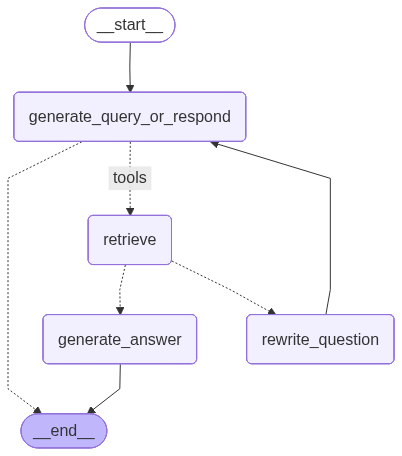

In [19]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## 8. Run the agentic RAG

Now let's test the complete graph by running it with a question:

In [30]:
r = graph.invoke({"messages": [("user", "What does Lilian Weng say about types of reward hacking?")]})
for v in r['messages']:
  v.pretty_print()

================================ Human Message =================================

What does Lilian Weng say about types of reward hacking?
================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_c0dedc91e18045108e69b1)
 Call ID: call_c0dedc91e18045108e69b1
  Args:
    query: types of reward hacking
================================= Tool Message =================================
Name: retrieve_blog_posts

Amodei et al. (2016) summarized that reward hacking, mainly in RL setting, may occur due to:

Detecting Reward Hacking#

Why does Reward Hacking Exist?#

(Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)
At a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering.
================================ Human Message ==============================

In [ ]:
# note: jupyter notebook 的输出配置可能截断输出，如果没看到完整的消息历史，调整输出配置即可。 
for chunk in graph.stream({"messages": [("user", "What does Lilian Weng say about types of reward hacking?")]}):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_2a00130eddbb4bb1b994c0)
 Call ID: call_2a00130eddbb4bb1b994c0
  Args:
    query: types of reward hacking



Update from node retrieve
================================= Tool Message =================================
Name: retrieve_blog_posts

Amodei et al. (2016) summarized that reward hacking, mainly in RL setting, may occur due to:

Detecting Reward Hacking#

Why does Reward Hacking Exist?#

(Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)
At a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering.



Update from node rewrite_question
================================ Human Message =================================

What are the different ty